<a href="https://colab.research.google.com/github/fongbubble/UoB_MGRCM0034_Group8_Car_Sales/blob/main/CarSaleCustomerSegment_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$$\text{Supanu Tanatammatid 2546980}$$

### Package

In [41]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from colorama import Fore, Style, init
import seaborn as sns
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import kagglehub
import os

### Data review

In [42]:
path = kagglehub.dataset_download("missionjee/car-sales-report")
print("Path to dataset files:", path)
files = os.listdir(path)
csv_file_path = os.path.join(path, files[0])
df = pd.read_csv(csv_file_path)
df.head(5)

Path to dataset files: /root/.cache/kagglehub/datasets/missionjee/car-sales-report/versions/1


,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


In [43]:
# DataFrame summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Car_id         23906 non-null  object
 1   Date           23906 non-null  object
 2   Customer Name  23905 non-null  object
 3   Gender         23906 non-null  object
 4   Annual Income  23906 non-null  int64 
 5   Dealer_Name    23906 non-null  object
 6   Company        23906 non-null  object
 7   Model          23906 non-null  object
 8   Engine         23906 non-null  object
 9   Transmission   23906 non-null  object
 10  Color          23906 non-null  object
 11  Price ($)      23906 non-null  int64 
 12  Dealer_No      23906 non-null  object
 13  Body Style     23906 non-null  object
 14  Phone          23906 non-null  int64 
 15  Dealer_Region  23906 non-null  object
dtypes: int64(3), object(13)
memory usage: 2.9+ MB


In [44]:
# Count duplicate rows
df.duplicated().sum()

0

In [45]:
# List unique values in 'Body Style' column
df['Body Style'].unique()

array(['SUV', 'Passenger', 'Hatchback', 'Hardtop', 'Sedan'], dtype=object)

### Correlation Heatmap

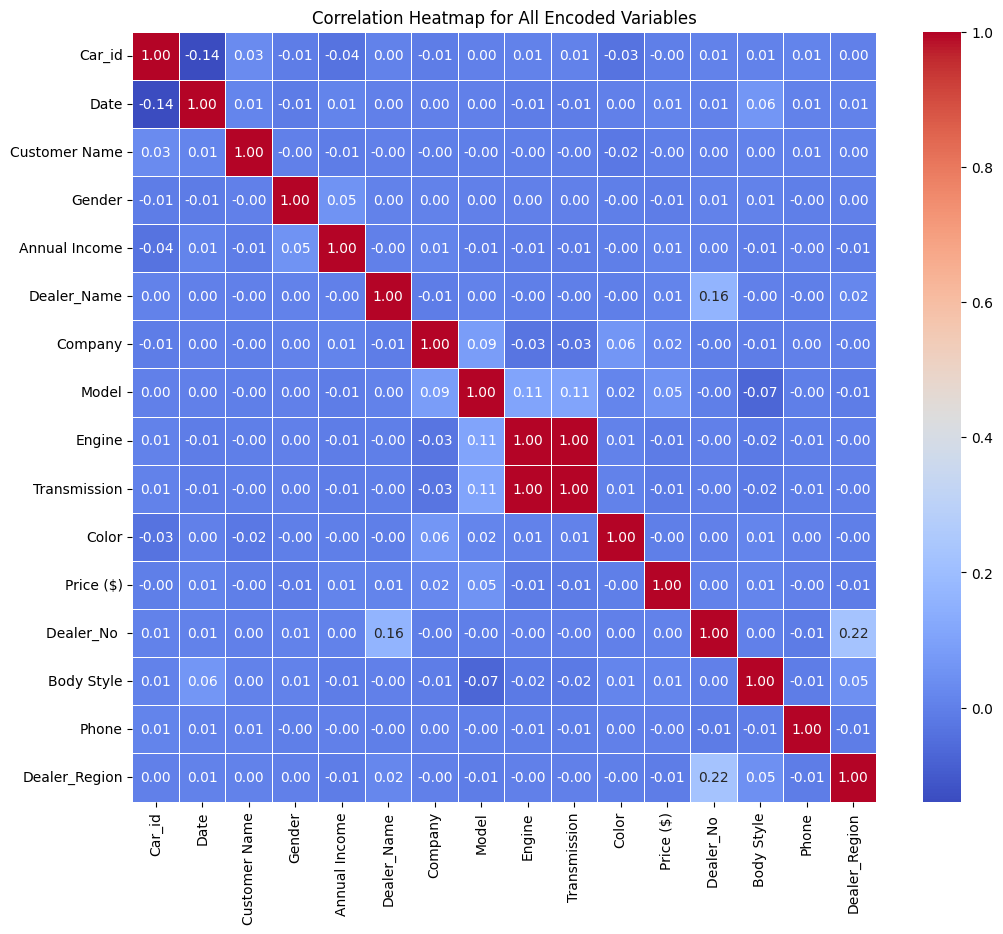

In [46]:
encoded_df = df.copy()
label_encoder = LabelEncoder()
for column in encoded_df.columns:
    if encoded_df[column].dtype == 'object':
        encoded_df[column] = label_encoder.fit_transform(encoded_df[column])
corr_matrix = encoded_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Heatmap for All Encoded Variables')
plt.show()

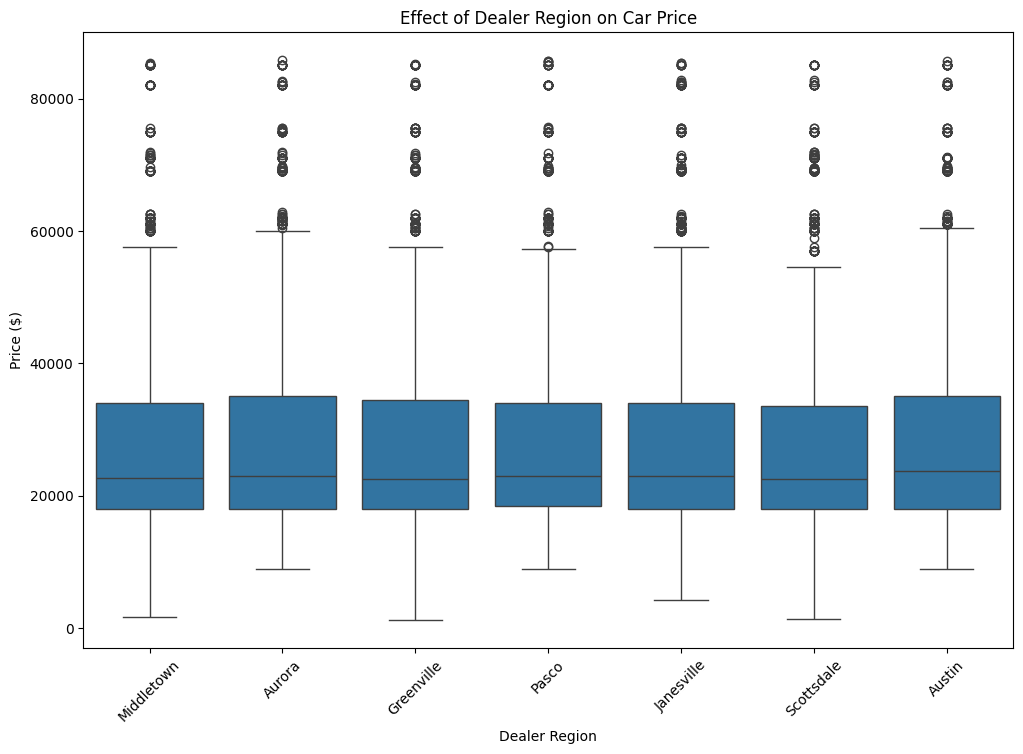

                            OLS Regression Results                            
Dep. Variable:         Q("Price ($)")   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7335
Date:                Mon, 02 Dec 2024   Prob (F-statistic):              0.623
Time:                        16:20:49   Log-Likelihood:            -2.6345e+05
No. Observations:               23906   AIC:                         5.269e+05
Df Residuals:                   23899   BIC:                         5.270e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [47]:
# Analyze how region affects the price of the car using a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Dealer_Region', y='Price ($)', data=df)
plt.xlabel('Dealer Region')
plt.ylabel('Price ($)')
plt.title('Effect of Dealer Region on Car Price')
plt.xticks(rotation=45)
plt.show()

# Linear regression to quantify the effect of region on price
model = smf.ols('Q("Price ($)") ~ C(Dealer_Region)', data=df).fit()
print(model.summary())

### Label Encoder

In [48]:
# Encode columns using LabelEncoder
columns_to_encode = ['Gender', 'Transmission', 'Body Style', 'Company', 'Model']
for col in columns_to_encode:
    df[f'{col}_Encoded'] = LabelEncoder().fit_transform(df[col])

### Standard Scaler

In [49]:
# Add Gender, Transmission, and Body Style to the feature matrix
X1 = df[['Annual Income', 'Price ($)', 'Company_Encoded', 'Model_Encoded']]
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

### Scatter plot

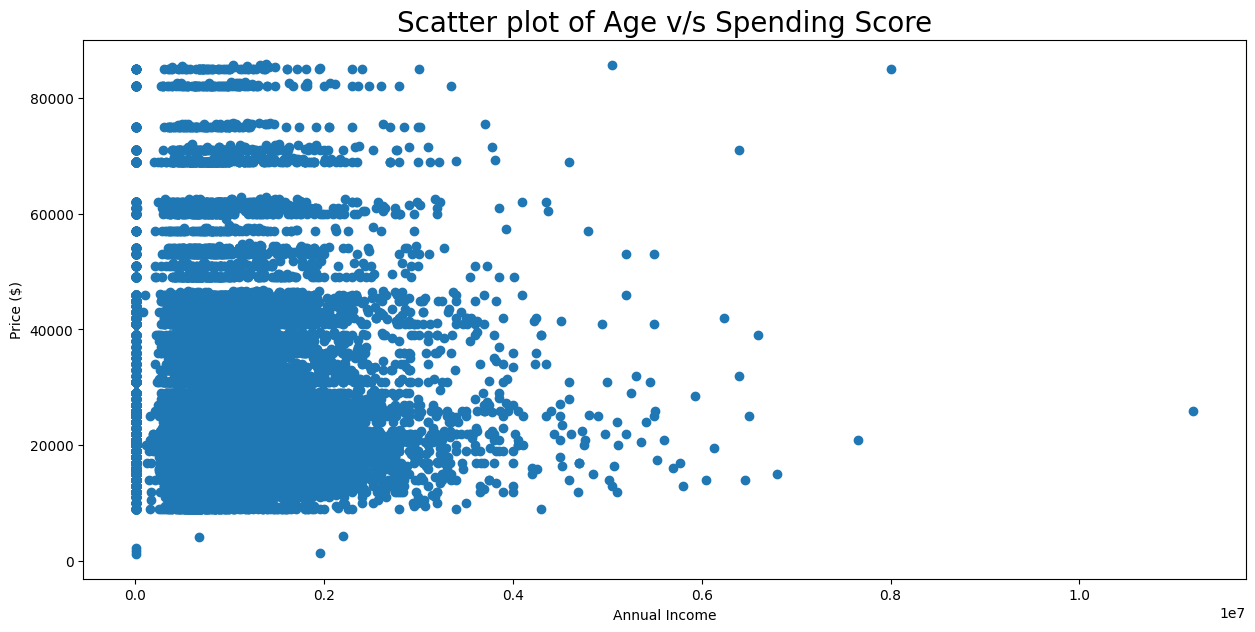

In [50]:
# Scatter plot of 'Annual Income' vs. 'Price ($)'
plt.figure(1, figsize=(15, 7))
plt.title('Scatter plot of Age v/s Spending Score', fontsize=20)
plt.xlabel('Annual Income')
plt.ylabel('Price ($)')
plt.scatter(x='Annual Income', y='Price ($)', data=df)
plt.show()

### Finding number of cluster by using elbow method

     Annual Income  Price ($)  Company_Encoded  Model_Encoded
PC1       0.059878   0.433216         0.604504       0.665818
PC2       0.953299   0.236723        -0.074452      -0.172160


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1418: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(


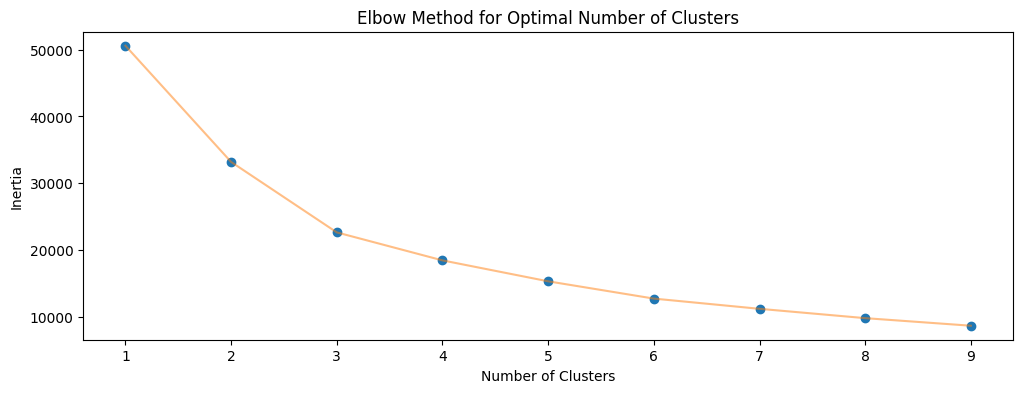

In [51]:
# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
X1_pca = pca.fit_transform(X1_scaled)

# Create DataFrame to visualize contributions of features to each principal component
components = pca.components_
features = ['Annual Income', 'Price ($)', 'Company_Encoded', 'Model_Encoded']
components_df = pd.DataFrame(components, columns=features, index=['PC1', 'PC2'])
print(components_df)

# Calculate inertia for different numbers of clusters to use the Elbow Method
inertia = []
for n in range(1, 10):
    algorithm = KMeans(n_clusters=n, init='k-means++', n_init=10, max_iter=300,
                       tol=0.0001, random_state=24150, algorithm='elkan')
    algorithm.fit(X1_pca)
    inertia.append(algorithm.inertia_)

# Plot the Elbow Method to determine the optimal number of clusters
plt.figure(1, figsize=(12, 4))
plt.plot(np.arange(1, 10), inertia, 'o')
plt.plot(np.arange(1, 10), inertia, '-', alpha=0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


### Feature Contribution

<ipython-input-52-e989d57d0f92>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  spectral_colors = cm.get_cmap('Spectral', len(features))


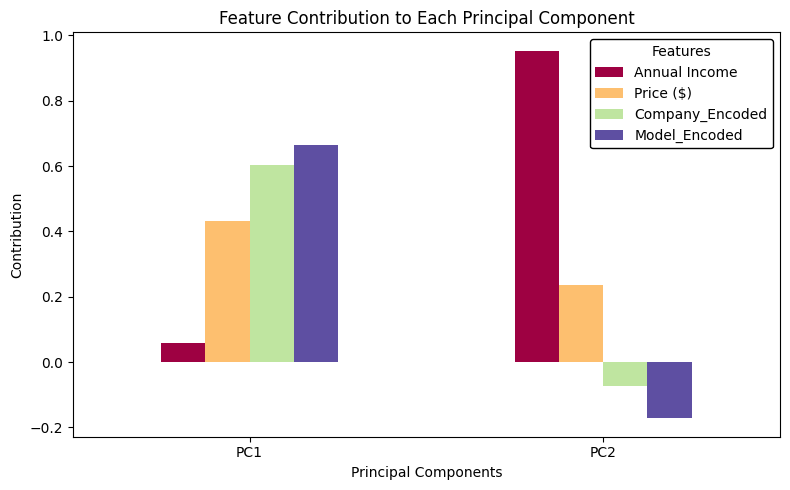

In [52]:
# Bar plot showing feature contribution to each principal component
components_df = pd.DataFrame(components, columns=features, index=['PC1', 'PC2'])
spectral_colors = cm.get_cmap('Spectral', len(features))
ax = components_df.plot(kind='bar', figsize=(8, 5), color=[spectral_colors(i) for i in range(len(features))])

plt.title('Feature Contribution to Each Principal Component')
plt.ylabel('Contribution')
plt.xlabel('Principal Components')
plt.xticks(rotation=0)
plt.legend(title='Features', loc='upper right', fancybox=True, framealpha=1, edgecolor='black', facecolor='white')
plt.tight_layout()  # Prevent clipping
plt.show()

### GridSearch to tune hyperparameter

In [53]:
# Define parameter grid for hyperparameter tuning using GridSearchCV
param_grid = {
    'n_clusters': [3, 4, 5, 6, 7, 8, 9],
    'init': ['k-means++', 'random'],
    'max_iter': [300, 500],
    'algorithm': ['auto', 'elkan']
}

# Perform grid search to find the best parameters for K-Means
kmeans = KMeans(random_state=24150)
grid_search = GridSearchCV(kmeans, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X1_pca)

# Use the best model identified by GridSearchCV
best_algorithm = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
140 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
123 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 886, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_

Best Parameters: {'algorithm': 'elkan', 'init': 'random', 'max_iter': 300, 'n_clusters': 9}


### PCA with K-means clustering

Car Brand and Model Recommendations for Each Cluster:
Mid-Income, Brand-Focused Buyers:
  Volvo: S40
  Toyota: Tacoma
  Saturn: SC
High-Income, Luxury Seekers:
  Ford: Mustang
  Dodge: Ram Pickup
  Chevrolet: Malibu
High-Income, Cost-Conscious Buyers:
  Chevrolet: Corvette
  Ford: Explorer
  Cadillac: Eldorado
Low-Income, Practical Buyers:
  Chevrolet: Prizm
  Ford: Expedition
  Dodge: Ram Pickup
Low-Income, Value-Driven Buyers:
  BMW: 323i
  Audi: A6
  Chrysler: 300M
Mid-Income, Budget-Conscious Buyers:
  Chevrolet: Prizm
  Ford: Explorer
  Dodge: Ram Pickup
High-Income, Brand-Focused Buyers:
  Volkswagen: Jetta
  Oldsmobile: Silhouette
  Toyota: Camry
Low-Income, Budget-Focused Buyers:
  Volkswagen: Passat
  Mercedes-B: S-Class
  Nissan: Pathfinder
Mid-Income, Practical Buyers:
  Volkswagen: Jetta
  Mercedes-B: S-Class
  Dodge: Viper


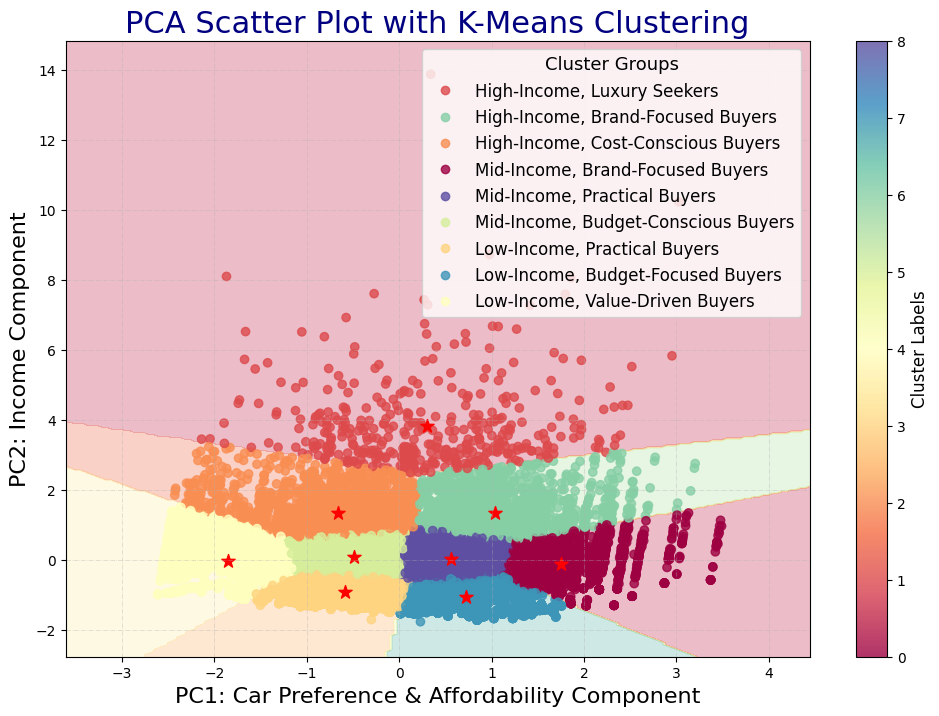

In [57]:
# Fit the best K-Means algorithm and assign cluster labels to DataFrame
algorithm = best_algorithm
algorithm.fit(X1_pca)
labels1 = algorithm.labels_
df['Cluster'] = labels1
centroids1 = algorithm.cluster_centers_

# Define descriptive names for each cluster
custom_cluster_names = [
    "Mid-Income, Brand-Focused Buyers",
    "High-Income, Luxury Seekers",
    "High-Income, Cost-Conscious Buyers",
    "Low-Income, Practical Buyers",
    "Low-Income, Value-Driven Buyers",
    "Mid-Income, Budget-Conscious Buyers",
    "High-Income, Brand-Focused Buyers",
    "Low-Income, Budget-Focused Buyers",
    "Mid-Income, Practical Buyers"
]

# Generate car brand and model recommendations for each cluster
cluster_recommendations = {}
for cluster in range(algorithm.n_clusters):
    cluster_data = df[df['Cluster'] == cluster]
    recommended_brands = cluster_data['Company'].value_counts().sort_values(ascending=False).head(3).index.tolist()
    brand_model_recommendations = {}
    for brand in recommended_brands:
        top_models = cluster_data[cluster_data['Company'] == brand]['Model'].value_counts().head(1).index.tolist()
        brand_model_recommendations[brand] = top_models
    cluster_recommendations[cluster] = brand_model_recommendations

# Print the car brand and model recommendations for each cluster
print("Car Brand and Model Recommendations for Each Cluster:")
for cluster, brand_models in cluster_recommendations.items():
    cluster_name = custom_cluster_names[cluster]
    print(f"{cluster_name}:")
    for brand, models in brand_models.items():
        print(f"  {brand}: {', '.join(models)}")

# Create mesh grid for visualizing K-Means clustering boundaries
x_min, x_max = X1_pca[:, 0].min() - 1, X1_pca[:, 0].max() + 1
y_min, y_max = X1_pca[:, 1].min() - 1, X1_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))

# Predict cluster labels for each point in the mesh grid
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot PCA scatter plot with K-Means clustering
plt.figure(figsize=(12, 8))
plt.title('PCA Scatter Plot with K-Means Clustering', fontsize=22, color='navy')
plt.xlabel('PC1: Car Preference & Affordability Component', fontsize=16)
plt.ylabel('PC2: Income Component', fontsize=16)

# Plot the decision boundary by assigning a color to each cluster area
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Spectral')

# Plot data points and centroids
scatter = plt.scatter(X1_pca[:, 0], X1_pca[:, 1], c=labels1, cmap='Spectral', alpha=0.8)
plt.scatter(centroids1[:, 0], centroids1[:, 1], s=100, c='red', marker='*', label='Centroids')

# Add color bar for clusters
cbar = plt.colorbar(scatter, ax=plt.gca())
cbar.set_label('Cluster Labels', fontsize=12)

# Reorder the legend entries based on income level (High, Mid, Low)
cluster_order = [
    "High-Income, Luxury Seekers",
    "High-Income, Brand-Focused Buyers",
    "High-Income, Cost-Conscious Buyers",
    "Mid-Income, Brand-Focused Buyers",
    "Mid-Income, Practical Buyers",
    "Mid-Income, Budget-Conscious Buyers",
    "Low-Income, Practical Buyers",
    "Low-Income, Budget-Focused Buyers",
    "Low-Income, Value-Driven Buyers"
]

handles, _ = scatter.legend_elements()
ordered_handles = [handles[custom_cluster_names.index(name)] for name in cluster_order]
plt.legend(ordered_handles, cluster_order, title="Cluster Groups", loc='upper right', fontsize=12, title_fontsize='13')

# Customize grid
plt.grid(True, linestyle='dashdot', linewidth=0.5, alpha=0.5)
plt.show()


### Predicting for the upcoming inputs

In [55]:
def recommend_car_for_new_customer(income, price):
    # Get the most frequent car model and encode it
    most_frequent_model = df['Model'].mode()[0]
    model_encoder = LabelEncoder().fit(df['Model'])
    model_encoded = model_encoder.transform([most_frequent_model])[0]

    # Get the most frequent car company and encode it
    most_frequent_company = df['Company'].mode()[0]
    company_encoder = LabelEncoder().fit(df['Company'])
    company_encoded = company_encoder.transform([most_frequent_company])[0]

    # Prepare the new customer's data for scaling and PCA transformation
    new_customer_data = np.array([[income, price, company_encoded, model_encoded]])
    new_customer_scaled = scaler.transform(new_customer_data)  # Standardize the new customer data
    new_customer_pca = pca.transform(new_customer_scaled)  # Apply PCA transformation
    predicted_cluster = best_algorithm.predict(new_customer_pca)[0]  # Predict the cluster
    cluster_name = custom_cluster_names[predicted_cluster]  # Get the descriptive cluster name

    # Filter cluster data to find relevant recommendations in the price range
    cluster_data = df[df['Cluster'] == predicted_cluster]
    price_lower_bound = price * 0.8  # Set lower price bound (80% of preferred price)
    price_upper_bound = price * 1.2  # Set upper price bound (120% of preferred price)
    price_filtered_data = cluster_data[(cluster_data['Price ($)'] >= price_lower_bound) &
                                       (cluster_data['Price ($)'] <= price_upper_bound)]

    # Decorated output
    print("\n=============================")
    print("🚗 CAR RECOMMENDATION SYSTEM")
    print("=============================\n")

    # If no cars are found in the desired price range
    if price_filtered_data.empty:
        print(f"No recommendations found in the price range of ${price_lower_bound:,.2f} - ${price_upper_bound:,.2f} for the '{cluster_name}' cluster.")
    else:
        # Provide car recommendations within the desired price range
        print(f"The new customer belongs to the '{cluster_name}' group.\n")
        print(f"Recommended Car Models in the Price Range ${price_lower_bound:,.2f} - ${price_upper_bound:,.2f}:\n")

        # Recommend top 5 car models from filtered data
        recommended_models = price_filtered_data.groupby(['Company', 'Model']).size().sort_values(ascending=False).head(5).index.tolist()
        for company, model in recommended_models:
            model_data = price_filtered_data[(price_filtered_data['Company'] == company) & (price_filtered_data['Model'] == model)]
            avg_price = model_data['Price ($)'].mean()
            body_type = model_data['Body Style'].mode()[0]
            transmission = model_data['Transmission'].mode()[0]
            print(f"  🚘 {company} {model}:")
            print(f"    - Average Price: ${avg_price:,.2f}")
            print(f"    - Body Type: {body_type}")
            print(f"    - Transmission: {transmission}\n")

# Get input from user for annual income and preferred price
print("Welcome to the Car Recommendation System!")
income = float(input("Enter your Annual Income (in dollars): "))
price = float(input("Enter your Preferred Price for a Car (in dollars): "))

# Make car recommendations for the new customer
recommend_car_for_new_customer(income, price)


Welcome to the Car Recommendation System!
Enter your Annual Income (in dollars): 2200000
Enter your Preferred Price for a Car (in dollars): 80000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🚗 CAR RECOMMENDATION SYSTEM

The new customer belongs to the 'High-Income, Luxury Seekers' group.

Recommended Car Models in the Price Range $64,000.00 - $96,000.00:

  🚘 Cadillac Catera:
    - Average Price: $75,000.50
    - Body Type: Hatchback
    - Transmission: Auto

  🚘 Lincoln Continental:
    - Average Price: $82,000.33
    - Body Type: Passenger
    - Transmission: Manual

  🚘 Mercury Grand Marquis:
    - Average Price: $71,166.67
    - Body Type: SUV
    - Transmission: Manual

  🚘 Nissan Pathfinder:
    - Average Price: $75,167.67
    - Body Type: Hardtop
    - Transmission: Auto

  🚘 Oldsmobile Aurora:
    - Average Price: $71,166.67
    - Body Type: Passenger
    - Transmission: Manual

